In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("gameInitiative (1).csv")

######## convert strings to time format
for col in ['createdAt', 'canceledAt', 'assignedAt']:
    df[col] = pd.to_datetime(df[col], format = "%H:%M:%S")

In [4]:
df.isna().sum() / df.shape[0]

createdAt     0.00000
canceledAt    0.66867
assignedAt    0.15239
rideId        0.00000
dtype: float64

In [5]:
######## compute time interval between cancel-create, assign-create in seconds
df.loc[(df['createdAt'] > df['canceledAt']), 'canceledAt'] = df['canceledAt'].apply(lambda x: x + datetime.timedelta(days = 1))
df.loc[(df['createdAt'] > df['assignedAt']), 'assignedAt'] = df['assignedAt'].apply(lambda x: x + datetime.timedelta(days = 1))

df['CancelTime'] = (df['canceledAt'] - df['createdAt']).dt.total_seconds()
df['AssignTime'] = (df['assignedAt'] - df['createdAt']).dt.total_seconds()

######### created binary variables to identify if a ride is canceled, and another for assigned
df['Iscanceled'] = np.where(df['canceledAt'].isna(), 'No', 'Yes')
df['IsAssigned'] = np.where(df['assignedAt'].isna(), 'No', 'Yes')



In [6]:
pd.crosstab(df['Iscanceled'], df['IsAssigned'])

IsAssigned,No,Yes
Iscanceled,,
No,5605,97730
Yes,17945,33258


17945 of rides have been canceled before assignment, we want to investigate effect of the "game" on these rides. if the game was lunched, what percent of these rides could be assigned to a driver ?

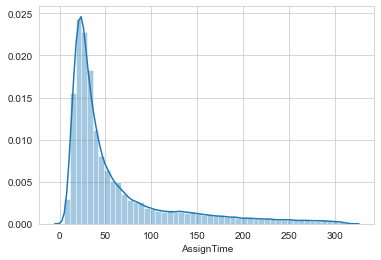

In [7]:
######## distribution of Assigning time
sns.distplot(df['AssignTime'])

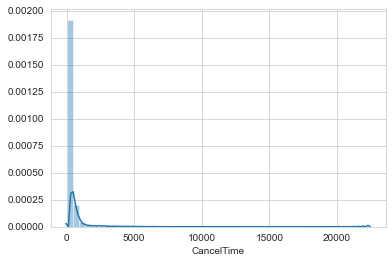

In [8]:
######## distribution of cancel time
sns.distplot(df['CancelTime'])

# 1) Simulation

in this section I will separate main data into two goups:

1) rides that have been assigned to a driver.(in this group rides may be canceled after assignment)

2) rides that got no driver and canceled by user.

In [9]:
assigned_rides = df[df['IsAssigned'] == 'Yes']
canceled_before_assign = df[(df['Iscanceled'] == 'Yes') & (df['IsAssigned'] == 'No')]

Text(0.5, 1.0, 'distribution of Cancel Time for rides with No driver assignment')

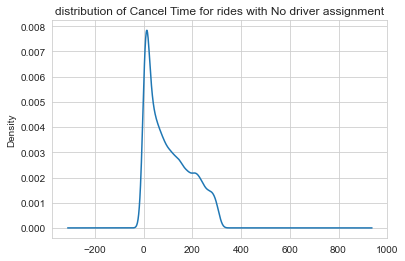

In [10]:
canceled_before_assign['CancelTime'].plot(kind = 'kde')
plt.title("distribution of Cancel Time for rides with No driver assignment")

### 1-1) GMM to estimate distribution of assignment times

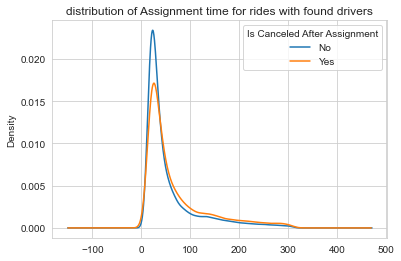

In [11]:
assigned_rides.groupby(['Iscanceled'])['AssignTime'].plot(kind = 'kde')
plt.title("distribution of Assignment time for rides with found drivers")
plt.legend(title = "Is Canceled After Assignment")

In [12]:
assigned_rides.groupby(['Iscanceled'])['AssignTime'].describe().T

Iscanceled,No,Yes
count,97730.000000,33258.000000
mean,56.496582,68.408894
std,57.022619,64.974087
min,5.000000,5.000000
25%,22.000000,25.000000
50%,33.000000,41.000000
75%,64.000000,86.000000
max,316.000000,315.000000


in this section I will perform model selection on GMM to find best model that could fit the distribution of assignment times

In [13]:
X = assigned_rides['AssignTime'].values.reshape(-1,1)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

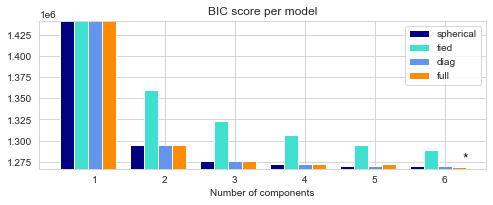

In [14]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

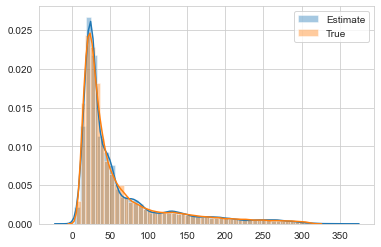

In [15]:
fig, ax = plt.subplots()

#### fit best gmm model that we found before
gm = GaussianMixture(n_components=6, covariance_type='full')
gm.fit(X)

####### plot GMM and emperical distribution of assignment times

sns.distplot(gm.sample(assigned_rides.shape[0])[0], label = 'Estimate', ax = ax)
sns.distplot(assigned_rides['AssignTime'].values, label = 'True', ax = ax)
plt.legend()

In [16]:
cancels = canceled_before_assign[['rideId', 'CancelTime', 'AssignTime']].copy()

In [17]:
improves = []

for i in tqdm(range(10000)):
    #### draw samples from assignment distribution (gmm) and assign as hypothetical assignmenttime for canceled rides
    cancels['AssignTime'] = gm.sample(cancels.shape[0])[0]
    #cancels['AssignTime'] = assigned_rides['AssignTime'].median()
    
    ##### draw sample from uniform(0,20)
    cancels['GameAddTime'] = np.random.uniform(low = 0.0, high = 20, size = cancels.shape[0])
    
    #### add previous values to canceltime
    cancels['CancelTimeImproved'] = cancels['CancelTime'] + cancels['GameAddTime']
    
    ##### count number of rides that could find ride due to additional time from game
    num_improves = cancels[(cancels['CancelTimeImproved'] > cancels['AssignTime']) & (cancels['CancelTime'] < cancels['AssignTime'])].shape[0]
    improves.append(num_improves)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.98it/s]


In [18]:
improves = np.array(improves) / cancels.shape[0]

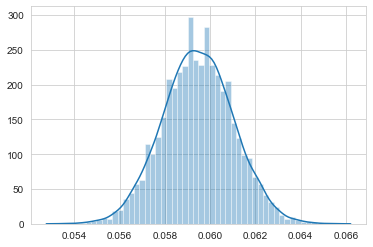

In [19]:
sns.distplot(improves)

In [20]:
improves.mean()

0.059464786848704376

result from simulation shows that if game was lunched, it could cause 6% of cancled rides from cancelation (i.e 6% of canceled rides would have been assigned to a driver.)

### 1-2) Use median

in this section istead of sampling from GMM, I will compute median of assignment time from rides that assigned to a driver, then use the median as hypothesis assignment time for canceled rides. (rides that been canceled before a driver found.)

In [29]:
cancels = canceled_before_assign[['rideId', 'CancelTime', 'AssignTime']].copy()
improves = []

for i in tqdm(range(10000)):
    #### use median of assignment time from assigned rides 
    cancels['AssignTime'] = assigned_rides['AssignTime'].median()
    
    ##### draw sample from uniform(0,20)
    cancels['GameAddTime'] = np.random.uniform(low = 0.0, high = 20, size = cancels.shape[0])
    
    #### add previous values to canceltime
    cancels['CancelTimeImproved'] = cancels['CancelTime'] + cancels['GameAddTime']
    
    ##### count number of rides that could find ride due to additional time from game
    num_improves = cancels[(cancels['CancelTimeImproved'] > cancels['AssignTime']) & (cancels['CancelTime'] < cancels['AssignTime'])].shape[0]
    improves.append(num_improves)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.21it/s]


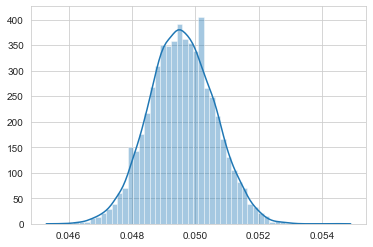

In [30]:
improves = np.array(improves) / cancels.shape[0]
sns.distplot(improves)

In [32]:
improves.mean()

0.049562914460852606

result from simulation with median of assigned times, shows that if game was lunched, it could cause 5% of cancled rides from cancelation (i.e 5% of canceled rides would have been assigned to a driver.). result from using a constant number (median) is very similar results from drawing samples from a distribution (GMM above.)

# 2) Simulation per hour

In [33]:
canceled_before_assign['create_hour'] = canceled_before_assign['createdAt'].dt.hour
assigned_rides['created_hour'] = assigned_rides['createdAt'].dt.hour

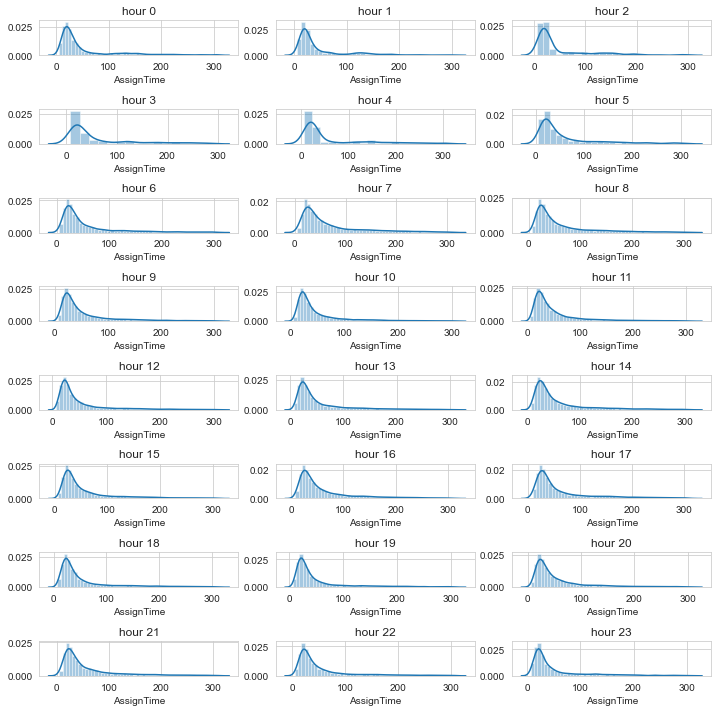

In [34]:
####### plot distribution of assignment times per hour
plt.figure(figsize = (10,10))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    sns.distplot(assigned_rides[assigned_rides['created_hour'] == i]['AssignTime'])
    plt.title(f"hour {i}")
    
plt.tight_layout()

### 2-1) USE GMM per hour and draw samples

in this section I will use different GMM models to estimate distribution of assignment times per hour, then use these GMMs for simulation. for every hour I will use it's own GMM model to draw samples for hypothetical assignment time of canceled rides.

In [35]:
gm_models = {i:GaussianMixture(n_components=6) for i in range(0,24)}


for i in tqdm(range(0,24)):
    x = assigned_rides[assigned_rides['created_hour'] == i]['AssignTime'].values.reshape(-1,1)
    gm_models[i].fit(x)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.37it/s]


In [36]:
improves = []
for i in tqdm(range(10000)):
    improve_per_hour = {}
    for hour in range(0,24):
        x = assigned_rides[assigned_rides['created_hour'] == hour]['AssignTime'].values.reshape(-1,1)
        cancel_tmp = canceled_before_assign[canceled_before_assign['create_hour'] == hour]
        cancel_tmp['AssignTime'] = gm_models[hour].sample(cancel_tmp.shape[0])[0]
        
        ##### draw sample from uniform(0,20)
        cancel_tmp['GameAddTime'] = np.random.uniform(low = 0.0, high = 20, size = cancel_tmp.shape[0])
    
        #### add previous values to canceltime
        cancel_tmp['CancelTimeImproved'] = cancel_tmp['CancelTime'] + cancel_tmp['GameAddTime']
        
        ##### count number of rides that could find ride due to additional time from game
        num_improves = cancel_tmp[(cancel_tmp['CancelTimeImproved'] > cancel_tmp['AssignTime']) & (cancel_tmp['CancelTime'] < cancel_tmp['AssignTime'])].shape[0]
        improve_per_hour[hour] = num_improves
        
    improves.append(improve_per_hour)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:26<00:00, 12.40it/s]


In [37]:
improves_df = pd.DataFrame(improves)
for i in range(0,24):
    #### canceled rides for each hour
    cancel_rides = canceled_before_assign[canceled_before_assign['create_hour'] == i].shape[0]
    
    #### divide number of rides that could have been succussful fue to game by total canceled rides of that hour
    improves_df.iloc[:, i] = improves_df.iloc[:, i] / cancel_rides

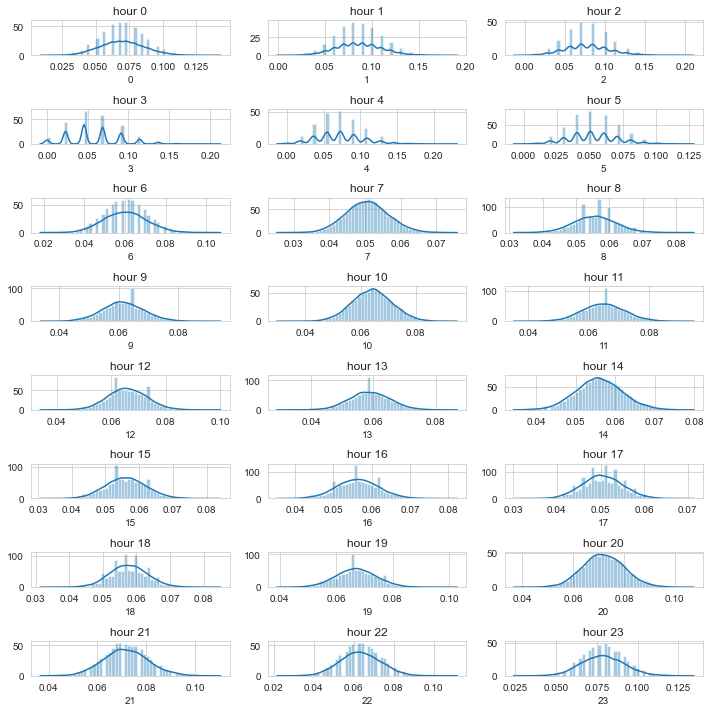

In [38]:
####### distribution of improvement rate per hour from simulation
plt.figure(figsize = (10,10))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    sns.distplot(improves_df.iloc[:, i])
    plt.title(f"hour {i}")
    
plt.tight_layout()

### 2-2) Use Median per hour

in this section for each hour I will compute median of assignment time from assigned rides and use as AssignTime for canceled rides of responding hour.

In [40]:
improves = []
for i in tqdm(range(10000)):
    improve_per_hour = {}
    for hour in range(0,24):
        x = assigned_rides[assigned_rides['created_hour'] == hour]['AssignTime'].values.reshape(-1,1)
        cancel_tmp = canceled_before_assign[canceled_before_assign['create_hour'] == hour]
        
        #### use median of assignment time from successful rides for hypothetical assignment time of canceled rides
        cancel_tmp['AssignTime'] = np.median(x)
        ##### draw sample from uniform(0,20)
        cancel_tmp['GameAddTime'] = np.random.uniform(low = 0.0, high = 20, size = cancel_tmp.shape[0])
    
        #### add previous values to canceltime
        cancel_tmp['CancelTimeImproved'] = cancel_tmp['CancelTime'] + cancel_tmp['GameAddTime']
        
        ##### count number of rides that could find ride due to additional time from game
        num_improves = cancel_tmp[(cancel_tmp['CancelTimeImproved'] > cancel_tmp['AssignTime']) & (cancel_tmp['CancelTime'] < cancel_tmp['AssignTime'])].shape[0]
        improve_per_hour[hour] = num_improves
        
    improves.append(improve_per_hour)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:48<00:00, 14.12it/s]


In [41]:
improves_df_median = pd.DataFrame(improves)
for i in range(0,24):
    #### canceled rides for each hour
    cancel_rides = canceled_before_assign[canceled_before_assign['create_hour'] == i].shape[0]
    
    #### divide number of rides that could have been succussful fue to game by total canceled rides of that hour
    improves_df_median.iloc[:, i] = improves_df_median.iloc[:, i] / cancel_rides

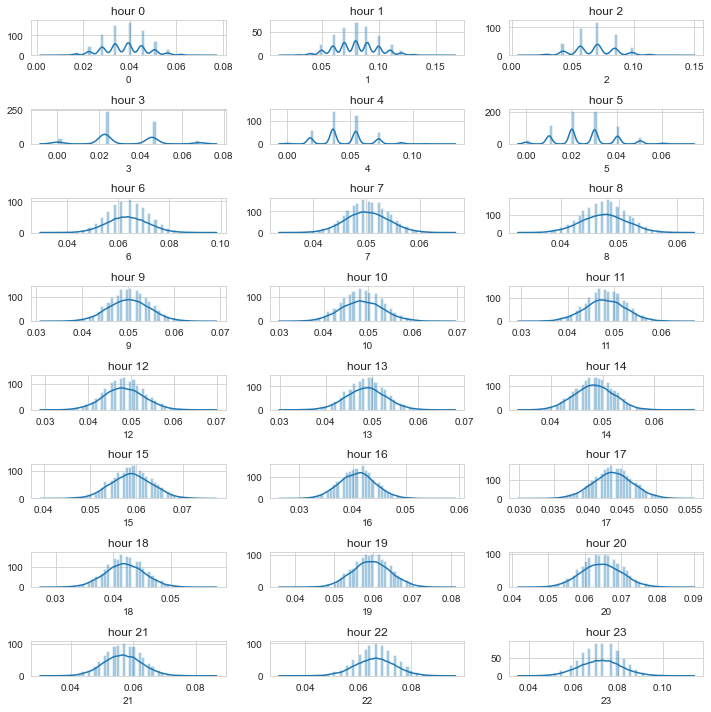

In [42]:
####### distribution of improvement rate per hour from simulation
plt.figure(figsize = (10,10))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    sns.distplot(improves_df_median.iloc[:, i])
    plt.title(f"hour {i}")
    
plt.tight_layout()

In [48]:
results = pd.concat([improves_df_median.median(), improves_df.median()], axis = 1)
results.columns = ['Use_Median', 'Use_GMM']

Text(0.5, 1.0, '%canceled rides could be assigned to driver with game')

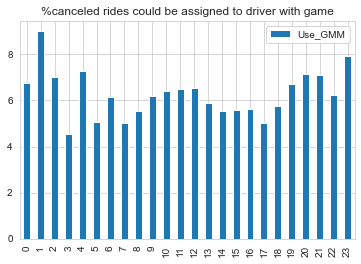

In [62]:
(100 * results['Use_GMM']).plot(kind = 'bar')
plt.legend()
plt.title("%canceled rides could be assigned to driver with game")

Text(0.5, 1.0, '% canceled rides could be assigned to driver with game')

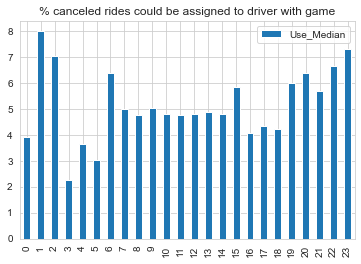

In [63]:
(results['Use_Median'] * 100).plot(kind = 'bar')
plt.legend()
plt.title("% canceled rides could be assigned to driver with game")

In [64]:
results

,Use_Median,Use_GMM
0,0.039326,0.067416
1,0.080000,0.090000
2,0.070423,0.070423
3,0.022727,0.045455
4,0.036364,0.072727
5,0.030303,0.050505
6,0.063939,0.061381
7,0.050137,0.050137
8,0.047801,0.055449
9,0.050515,0.061856


In [55]:
results['Use_GMM'].mean()

0.06274747290419604

In [56]:
results['Use_Median'].mean()

0.051622203636128385